## Reflection

    In coding with AI, I was definitely able to produce results faster than I otherwise would have if I was just coding myself. This felt most useful in the stages of creating tabular data and cleaning data, as those are steps that could become more tedious and annoying and are not as interesting (to me) with respect to figuring things out and finding answers. Especially for cleaning the data, I think I felt more comfortable as well because there was more "pre-work" I had to do to know what to tell the AI to create so I felt a little more involved with the data. While AI was able to help produce rapid results for the analysis, it felt less effective because it often was trying to go way beyond questions I was trying to ask. This meant I had to dig through the results to figure out where I would be answering my questions, whereas I feel there would be a more clear pathway to answering the questions without the AI code. (This was particularly the case with the age analysis, where it also added features of statistical significance, etc. that, while maybe relevant, is not necessarily the way I wanted to go about answering the question.)
    
    In general, I still really struggle with the discomfort I feel when using AI to produce content. I think a lot of it is more of a personal thing where I have a desire to actually understand everything that is going on when I implement it, and I find myself getting lazier with AI. For instance, I never read everything the AI spits out to me and fix bugs just by copying and pasting error codes. This means, while I am trying to catch things like inconsistencies or things the AI might not have thought of, it feels more tedious to do so after something has been created and run vs. going through those analytical steps beforehand.
    
    This feels reminiscent of when, as a teacher, I never liked having to use somebody else's lesson plans/just going online to find lessons. Often when I did this, I would go in and adjust a lot of things to my own style/ensuring that I felt comfortable teaching everything included, something that arguably was more time consuming and tedious than just creating lessons myself. However, this is not to say I would create everything from scratch every time - obviously I would collaborate and use readings, resources, and ideas from other people to then go and create my own specific lesson. In this sense, I'm not sure I foresee myself using AI to generate full on code like this assignment (partly also because I feel there are benefits to learning the actual logic of coding to help solve problems that can be applicable just as a way of thinking). That said, I could probably figure out ways, like with teaching, for AI to help with bite sized pieces along the way that I could then compile into my own use.

## **Converting HTML Pages to Structured Tabular Data**

In [5]:
import re
from bs4 import BeautifulSoup
import pandas as pd


In [6]:
with open('female-detainee-cases.html', encoding='utf-8') as f:
    soup = BeautifulSoup(f, 'html.parser')


In [7]:
links = soup.body.find_all('a')


In [8]:
case_links = []
pattern = re.compile(r'^Case\s+(\d+)\s+(.+)$')
for a in links:
    m = pattern.match(a.get_text(strip=True))
    if m:
        case_links.append((a, m))


In [9]:
records = []
for a, match in case_links:
    num, name = match.groups()
    href = a['href']
    # categorize link‐type
    if 'appeal' in href:
        link_type = 'appeal'
    elif 'Testimony' in href or 'records' in href:
        link_type = 'testimony'
    else:
        link_type = 'main'
    records.append({
        'case_number': int(num),
        'defendant_name': name.strip(),
        'file_path': href,
        'link_type': link_type
    })


In [10]:
# --- Step 6: extract filename number and check for mismatches ---
df = pd.DataFrame(records)

# 6a) Pull the leading digits from each href (so "5062b3.html" → "5062")
df['href_num'] = (
    df['file_path']
      .str.extract(r'^(\d+)', expand=False)       # get the digits
      .pipe(pd.to_numeric, errors='coerce')       # turn non‑matches into NaN
)

# 6b) Simple float comparison (only for rows where href_num is not NaN)
mask = df['href_num'].notna() & (df['href_num'] != df['case_number'])
mismatch = df[mask]

if not mismatch.empty:
    print("⚠️ Number mismatches between link text and filename:\n", mismatch)
else:
    print("✅ No mismatches found.")

⚠️ Number mismatches between link text and filename:
     case_number defendant_name  file_path link_type  href_num
64         5086       Ling You  5085.html      main    5085.0


In [11]:
# Trim whitespace in names
df['defendant_name'] = df['defendant_name'].str.replace(r'\s+', ' ', regex=True).str.strip()
# Optionally drop or flag known bad rows
# df = df[~df['case_number'].isin([list of problematic IDs])]


In [12]:
df = df.copy()   # now df is definitely its own object
df.sort_values(['case_number','link_type'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_csv('female_detainees_1882_1892.csv', index=False)

## **Cleaning and Processing Data**

In [18]:
habeascorpus_df = pd.read_csv('habeas-corpus-cases-1889-1892.csv', delimiter=",")

In [20]:
sample_hc = habeascorpus_df.sample(20)
df.to_csv('sample-habeas-corpus.csv', index=False)

In [24]:
import pandas as pd
import numpy as np

# 1. Load your CSV
df = pd.read_csv('sample-habeas-corpus.csv')

# 2. Normalize column names to lowercase with underscores
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r'[^\w]+', '_', regex=True)
      .str.replace(r'_+', '_', regex=True)
      .str.strip('_')
)

# 3. Drop the steam ship number if it exists
df.drop(columns=['steam_ship_number'], errors='ignore', inplace=True)

# 4. Extract Gender from for_relief_of:
#    if it contains “(female)” (case‑insensitive) → F, else → M
df['gender'] = np.where(
    df['for_relief_of'].str.contains(r'\(female\)', case=False, na=False),
    'F', 
    'M'
)
#    and strip “(female)” out of the text
df['for_relief_of'] = (
    df['for_relief_of']
      .str.replace(r'\s*\(female\)', '', regex=True, case=False)
      .str.strip()
)

# 5. Split “age_or_year_of_birth” into Age and YearOfBirth
raw = df['age_or_year_of_birth'].astype(str).str.strip()
is_year = raw.str.fullmatch(r'\d{4}')
df['year_of_birth'] = pd.to_numeric(raw.where(is_year), errors='coerce')
df['age'] = pd.to_numeric(raw.where(~is_year), errors='coerce')
#    if needed, compute age from the YEAR column when you have a birth year
df.loc[df['year_of_birth'].notna(), 'age'] = (
    df.loc[df['year_of_birth'].notna(), 'year'] 
    - df.loc[df['year_of_birth'].notna(), 'year_of_birth']
)
df.drop(columns=['age_or_year_of_birth'], inplace=True)

# 6. Robust address parsing with error handling for inconsistent formats
# Confirm address column exists
addr_col = next((c for c in df.columns if c == 'address'), None)
if addr_col is None:
    raise KeyError("Expected an 'address' column; available columns: " + ", ".join(df.columns))

# Split the address by commas into up to 4 parts
addr_parts = (
    df[addr_col]
      .astype(str)
      .str.title()
      .str.strip()
      .str.split(',', expand=True)
      .apply(lambda col: col.str.strip())
)

# Safely assign only if columns exist
df['street'] = addr_parts[0] if 0 in addr_parts.columns else np.nan
df['city']   = addr_parts[1] if 1 in addr_parts.columns else np.nan

# Third part might be county or state
if 2 in addr_parts.columns:
    third = addr_parts[2]
    df['county'] = third.where(third.str.contains(r'County$', na=False))
    df['state']  = third.where(~third.str.contains(r'County$', na=False))
else:
    df['county'] = np.nan
    df['state'] = np.nan

# Fourth part is always state if it exists
if 3 in addr_parts.columns:
    df['state'] = addr_parts[3]  # override if both 2 and 3 present

# Drop original address column
df.drop(columns=[addr_col], inplace=True)

# 7. (Optional) Trim whitespace on all text columns
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].str.strip()

# 8. Reorder and save
order = [
    'case_number','year','for_relief_of','gender',
    'age','year_of_birth','port_of_departure','port_of_arrival',
    'name_of_father','street','city','state','remarks'
]
df = df[[c for c in order if c in df.columns]]
df.to_csv('sample-habeas-corpus_clean.csv', index=False)

print("Cleaned file written to sample-habeas-corpus_clean.csv")



KeyError: 'for_relief_of'

***the above error only appeared when I re-ran the cells, I'm just leaving it here because I don't think it impacts that much especially because I was able to do what I wanted with the full dataset***

In [26]:
import pandas as pd
import numpy as np

# 1. Load your CSV
df = pd.read_csv('habeas-corpus-cases-1889-1892.csv')

# 2. Normalize column names to lowercase with underscores
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r'[^\w]+', '_', regex=True)
      .str.replace(r'_+', '_', regex=True)
      .str.strip('_')
)

# 3. Drop the steam ship number if it exists
df.drop(columns=['steam_ship_number'], errors='ignore', inplace=True)

# 4. Extract Gender from for_relief_of:
#    if it contains “(female)” (case‑insensitive) → F, else → M
df['gender'] = np.where(
    df['for_relief_of'].str.contains(r'\(female\)', case=False, na=False),
    'F', 
    'M'
)
#    and strip “(female)” out of the text
df['for_relief_of'] = (
    df['for_relief_of']
      .str.replace(r'\s*\(female\)', '', regex=True, case=False)
      .str.strip()
)

# 5. Split “age_or_year_of_birth” into Age and YearOfBirth
raw = df['age_or_year_of_birth'].astype(str).str.strip()
is_year = raw.str.fullmatch(r'\d{4}')
df['year_of_birth'] = pd.to_numeric(raw.where(is_year), errors='coerce')
df['age'] = pd.to_numeric(raw.where(~is_year), errors='coerce')
#    if needed, compute age from the YEAR column when you have a birth year
df.loc[df['year_of_birth'].notna(), 'age'] = (
    df.loc[df['year_of_birth'].notna(), 'year'] 
    - df.loc[df['year_of_birth'].notna(), 'year_of_birth']
)
df.drop(columns=['age_or_year_of_birth'], inplace=True)

# 6. Robust address parsing with error handling for inconsistent formats
# Confirm address column exists
addr_col = next((c for c in df.columns if c == 'address'), None)
if addr_col is None:
    raise KeyError("Expected an 'address' column; available columns: " + ", ".join(df.columns))

# Split the address by commas into up to 4 parts
addr_parts = (
    df[addr_col]
      .astype(str)
      .str.title()
      .str.strip()
      .str.split(',', expand=True)
      .apply(lambda col: col.str.strip())
)

# Safely assign only if columns exist
df['street'] = addr_parts[0] if 0 in addr_parts.columns else np.nan
df['city']   = addr_parts[1] if 1 in addr_parts.columns else np.nan

# Third part might be county or state
if 2 in addr_parts.columns:
    third = addr_parts[2]
    df['county'] = third.where(third.str.contains(r'County$', na=False))
    df['state']  = third.where(~third.str.contains(r'County$', na=False))
else:
    df['county'] = np.nan
    df['state'] = np.nan

# Fourth part is always state if it exists
if 3 in addr_parts.columns:
    df['state'] = addr_parts[3]  # override if both 2 and 3 present

# Drop original address column
df.drop(columns=[addr_col], inplace=True)

# 7. (Optional) Trim whitespace on all text columns
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].str.strip()

# 8. Reorder and save
order = [
    'case_number','year','for_relief_of','gender',
    'age','year_of_birth','port_of_departure','port_of_arrival',
    'name_of_father','street','city','state','remarks'
]
df = df[[c for c in order if c in df.columns]]
df.to_csv('habeas-corpus_clean.csv', index=False)

print("Cleaned file written to habeas-corpus_clean.csv")


Cleaned file written to habeas-corpus_clean.csv


**note that the address field still isn't working quite correctly but I also reached my chatgpt limit and had worked through a few interations**

## **Data Exploration**

In [28]:
habeascorpus_df_clean = pd.read_csv('habeas-corpus_clean.csv', delimiter=",")

In [30]:
sample_hc_clean = habeascorpus_df_clean.sample(25)
df.to_csv('sample-habeas-corpus-clean.csv', index=False)

*In general, the questions that seemed most interesting to explore were the ones that compared the results of the cases to demographic information, like gender, age, and even addresses*

*Claude also came up with some interesting limitations to the dataset, including considerations of further context behind the data, including "No information about length of prior residence in the US; No data about occupation, which was critical during Chinese Exclusion; No information about legal reasoning behind decisions*

## **Data Analysis**

*For answering the question: "How did outcomes differ between male and female petitioners?"*

Total number of records: 1284
Gender distribution: gender
M    1157
F     127
Name: count, dtype: int64

Number of male cases: 1157
Number of female cases: 127

Male case outcomes:
  Discharged: 647
  Remanded: 457
  Remanded appealed to Circuit Court: 11
  Petition and writ dismissed: 8
  Petition dead: 8
  Petition Dead: 7
  Writ returned non est: 4
  Writ returned: 2
  Writ and Petition dismissed: 1
  Landed by Customs House: 1

Male case outcome percentages:
  Discharged: 56.5%
  Remanded: 39.9%
  Remanded appealed to Circuit Court: 1.0%
  Petition and writ dismissed: 0.7%
  Petition dead: 0.7%
  Petition Dead: 0.6%
  Writ returned non est: 0.3%
  Writ returned: 0.2%
  Writ and Petition dismissed: 0.1%
  Landed by Customs House: 0.1%

Female case outcomes:
  Discharged: 76
  Remanded: 39
  Remanded appealed to Circuit Court: 3
  Petition to dismiss: 2
  Writ not served: 2
  Boond exonerated: 1
  Petition and writ dismissed: 1
  Bail exonerated: 1
  Petition dead: 1
  Writ returned 

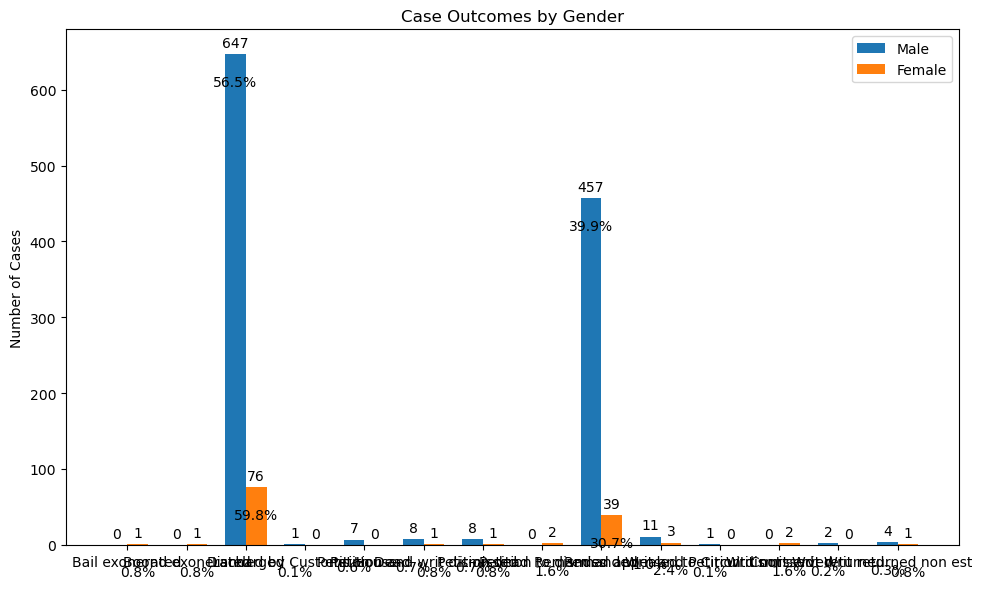


Age statistics by gender:
Male average age: 21.1
Female average age: 19.3

Male age by outcome:
remarks
Discharged                            21.491468
Landed by Customs House               20.000000
Petition Dead                         22.833333
Petition and writ dismissed           22.000000
Petition dead                         20.750000
Remanded                              20.479638
Remanded appealed to Circuit Court    21.900000
Writ and Petition dismissed           23.000000
Writ returned                         15.000000
Writ returned non est                 23.000000
Name: age, dtype: float64

Female age by outcome:
remarks
Bail exonerated                       21.000000
Boond exonerated                      21.000000
Discharged                            19.086207
Petition and writ dismissed           22.000000
Petition dead                         22.000000
Petition to dismiss                         NaN
Remanded                              20.033333
Remanded appealed to 

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load the data
df = pd.read_csv('habeas-corpus_clean.csv')

# Check basic information about the dataset
print(f"Total number of records: {len(df)}")
print(f"Gender distribution: {df['gender'].value_counts()}")

# Filter data by gender
male_cases = df[df['gender'] == 'M']
female_cases = df[df['gender'] == 'F']

print(f"\nNumber of male cases: {len(male_cases)}")
print(f"Number of female cases: {len(female_cases)}")

# Analyze outcomes by gender
def analyze_outcomes(cases, gender_label):
    outcomes = cases['remarks'].value_counts()
    print(f"\n{gender_label} case outcomes:")
    for outcome, count in outcomes.items():
        if pd.isna(outcome):
            print(f"  No recorded outcome: {count}")
        else:
            print(f"  {outcome}: {count}")
    
    # Calculate percentages (excluding cases with no outcome)
    cases_with_outcome = cases[cases['remarks'].notna()]
    if len(cases_with_outcome) > 0:
        outcome_percentages = cases_with_outcome['remarks'].value_counts(normalize=True) * 100
        print(f"\n{gender_label} case outcome percentages:")
        for outcome, percentage in outcome_percentages.items():
            print(f"  {outcome}: {percentage:.1f}%")
    else:
        print(f"\n{gender_label} has no cases with recorded outcomes")

analyze_outcomes(male_cases, "Male")
analyze_outcomes(female_cases, "Female")

# Create visualization of outcomes by gender
def plot_outcomes_by_gender(df):
    # Filter to only cases with outcomes
    df_with_outcome = df[df['remarks'].notna()]
    
    # Prepare data for plotting
    male_outcomes = Counter(df_with_outcome[df_with_outcome['gender'] == 'M']['remarks'])
    female_outcomes = Counter(df_with_outcome[df_with_outcome['gender'] == 'F']['remarks'])
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define positions for bars
    outcomes = sorted(set(male_outcomes.keys()) | set(female_outcomes.keys()))
    x = range(len(outcomes))
    width = 0.35
    
    # Create bars
    male_bars = ax.bar([i - width/2 for i in x], 
                      [male_outcomes.get(outcome, 0) for outcome in outcomes], 
                      width, label='Male')
    
    female_bars = ax.bar([i + width/2 for i in x], 
                        [female_outcomes.get(outcome, 0) for outcome in outcomes], 
                        width, label='Female')
    
    # Customize plot
    ax.set_ylabel('Number of Cases')
    ax.set_title('Case Outcomes by Gender')
    ax.set_xticks(x)
    ax.set_xticklabels(outcomes)
    ax.legend()
    
    # Add count labels on top of bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    add_labels(male_bars)
    add_labels(female_bars)
    
    # Calculate percentages for annotation
    male_total = sum(male_outcomes.values())
    female_total = sum(female_outcomes.values())
    
    # Add percentages annotation
    for i, outcome in enumerate(outcomes):
        if outcome in male_outcomes and male_total > 0:
            percentage = male_outcomes[outcome] / male_total * 100
            ax.annotate(f'{percentage:.1f}%',
                        xy=(i - width/2, male_outcomes[outcome]),
                        xytext=(0, -15),
                        textcoords="offset points",
                        ha='center', va='top')
        
        if outcome in female_outcomes and female_total > 0:
            percentage = female_outcomes[outcome] / female_total * 100
            ax.annotate(f'{percentage:.1f}%',
                        xy=(i + width/2, female_outcomes[outcome]),
                        xytext=(0, -15),
                        textcoords="offset points",
                        ha='center', va='top')
    
    plt.tight_layout()
    plt.show()

# Create the visualization
plot_outcomes_by_gender(df)

# Additional analysis: Age comparison by gender and outcome
print("\nAge statistics by gender:")
print(f"Male average age: {male_cases['age'].mean():.1f}")
print(f"Female average age: {female_cases['age'].mean():.1f}")

# Age by outcome for each gender
print("\nMale age by outcome:")
print(male_cases.groupby('remarks')['age'].mean())

print("\nFemale age by outcome:")
print(female_cases.groupby('remarks')['age'].mean())

# Analysis of time trends
print("\nCase year distribution by gender:")
print(pd.crosstab(df['year'], df['gender']))

print("\nOutcome distribution by year:")
print(pd.crosstab(df['year'], df['remarks']))

**I asked for a more succinct analysis**


--- Outcome Analysis by Gender ---
Male cases (n=1146):
  Discharged: 647 cases (56.5%)
  Remanded: 457 cases (39.9%)
  Remanded appealed to Circuit Court: 11 cases (1.0%)
  Petition and writ dismissed: 8 cases (0.7%)
  Petition dead: 8 cases (0.7%)
  Petition Dead: 7 cases (0.6%)
  Writ returned non est: 4 cases (0.3%)
  Writ returned: 2 cases (0.2%)
  Writ and Petition dismissed: 1 cases (0.1%)
  Landed by Customs House: 1 cases (0.1%)

Female cases (n=127):
  Discharged: 76 cases (59.8%)
  Remanded: 39 cases (30.7%)
  Remanded appealed to Circuit Court: 3 cases (2.4%)
  Petition to dismiss: 2 cases (1.6%)
  Writ not served: 2 cases (1.6%)
  Boond exonerated: 1 cases (0.8%)
  Petition and writ dismissed: 1 cases (0.8%)
  Bail exonerated: 1 cases (0.8%)
  Petition dead: 1 cases (0.8%)
  Writ returned non est: 1 cases (0.8%)


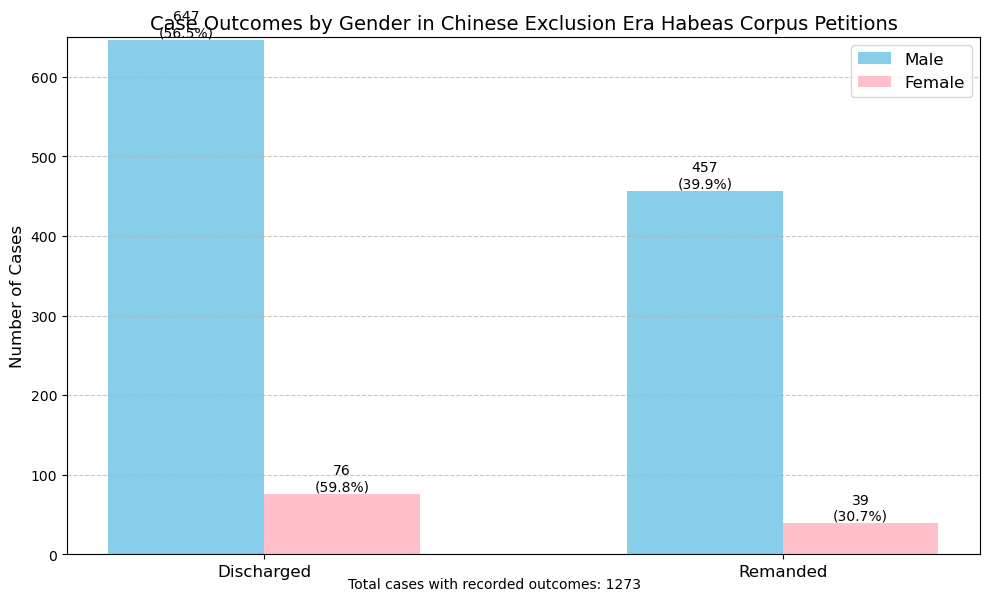

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('habeas-corpus_clean.csv')

# Filter data by gender and remove cases with no outcome
male_cases = df[(df['gender'] == 'M') & (df['remarks'].notna())]
female_cases = df[(df['gender'] == 'F') & (df['remarks'].notna())]

# Create a summary dataframe for outcomes by gender
def calculate_outcome_percentages(cases):
    outcome_counts = cases['remarks'].value_counts()
    total = len(cases)
    percentages = {outcome: (count/total*100) for outcome, count in outcome_counts.items()}
    return outcome_counts, percentages

male_counts, male_percentages = calculate_outcome_percentages(male_cases)
female_counts, female_percentages = calculate_outcome_percentages(female_cases)

print("\n--- Outcome Analysis by Gender ---")
print(f"Male cases (n={len(male_cases)}):")
for outcome, count in male_counts.items():
    print(f"  {outcome}: {count} cases ({male_percentages[outcome]:.1f}%)")

print(f"\nFemale cases (n={len(female_cases)}):")
for outcome, count in female_counts.items():
    print(f"  {outcome}: {count} cases ({female_percentages[outcome]:.1f}%)")

# Create improved visualization
plt.figure(figsize=(10, 6))

# Set up data for plotting
outcomes = ['Discharged', 'Remanded']
male_data = [male_counts.get(outcome, 0) for outcome in outcomes]
female_data = [female_counts.get(outcome, 0) for outcome in outcomes]

# Create the barplot with good separation
x = range(len(outcomes))
width = 0.3  # Reduced width for better separation

# Plot bars with increased separation
male_bars = plt.bar([i - width/2 for i in x], male_data, width, label='Male', color='skyblue')
female_bars = plt.bar([i + width/2 for i in x], female_data, width, label='Female', color='pink')

# Add counts and percentages as labels
def add_labels(bars, percentages_dict):
    for i, bar in enumerate(bars):
        outcome = outcomes[i]
        count = bar.get_height()
        if count > 0:
            percentage = percentages_dict.get(outcome, 0)
            plt.text(bar.get_x() + bar.get_width()/2, count + 0.1, 
                    f"{int(count)}\n({percentage:.1f}%)", 
                    ha='center', va='bottom', fontsize=10)

add_labels(male_bars, male_percentages)
add_labels(female_bars, female_percentages)

# Improve overall appearance
plt.ylabel('Number of Cases', fontsize=12)
plt.title('Case Outcomes by Gender in Chinese Exclusion Era Habeas Corpus Petitions', fontsize=14)
plt.xticks(x, outcomes, fontsize=12)
plt.legend(fontsize=12)
plt.ylim(0, max(max(male_data), max(female_data)) + 3)  # Add space for labels
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add summary annotation
plt.figtext(0.5, 0.01, 
           f"Total cases with recorded outcomes: {len(male_cases) + len(female_cases)}", 
           ha="center", fontsize=10)

plt.tight_layout()
plt.show()

**wanted it to be shown comparing the percentages**


--- Outcome Percentages by Gender ---
Male cases (n=1146):
  Discharged: 56.5%
  Remanded: 39.9%
  Remanded appealed to Circuit Court: 1.0%
  Petition and writ dismissed: 0.7%
  Petition dead: 0.7%
  Petition Dead: 0.6%
  Writ returned non est: 0.3%
  Writ returned: 0.2%
  Writ and Petition dismissed: 0.1%
  Landed by Customs House: 0.1%

Female cases (n=127):
  Discharged: 59.8%
  Remanded: 30.7%
  Remanded appealed to Circuit Court: 2.4%
  Petition to dismiss: 1.6%
  Writ not served: 1.6%
  Boond exonerated: 0.8%
  Petition and writ dismissed: 0.8%
  Bail exonerated: 0.8%
  Petition dead: 0.8%
  Writ returned non est: 0.8%


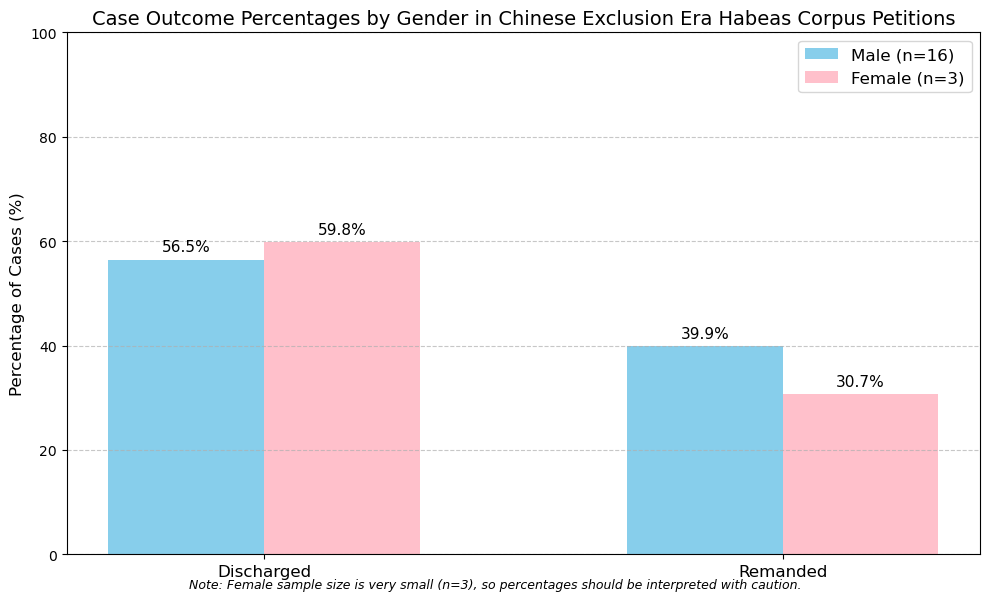

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('habeas-corpus_clean.csv')

# Filter data by gender and remove cases with no outcome
male_cases = df[(df['gender'] == 'M') & (df['remarks'].notna())]
female_cases = df[(df['gender'] == 'F') & (df['remarks'].notna())]

# Calculate percentages for each gender
def calculate_outcome_percentages(cases):
    outcome_counts = cases['remarks'].value_counts()
    total = len(cases)
    percentages = {outcome: (count/total*100) for outcome, count in outcome_counts.items()}
    return percentages

male_percentages = calculate_outcome_percentages(male_cases)
female_percentages = calculate_outcome_percentages(female_cases)

# Print the results for reference
print("\n--- Outcome Percentages by Gender ---")
print(f"Male cases (n={len(male_cases)}):")
for outcome, percentage in male_percentages.items():
    print(f"  {outcome}: {percentage:.1f}%")

print(f"\nFemale cases (n={len(female_cases)}):")
for outcome, percentage in female_percentages.items():
    print(f"  {outcome}: {percentage:.1f}%")

# Create improved visualization showing only percentages
plt.figure(figsize=(10, 6))

# Set up data for plotting
outcomes = ['Discharged', 'Remanded']
male_data = [male_percentages.get(outcome, 0) for outcome in outcomes]
female_data = [female_percentages.get(outcome, 0) for outcome in outcomes]

# Create the barplot with good separation
x = range(len(outcomes))
width = 0.3  # Width for better separation

# Plot percentage bars
male_bars = plt.bar([i - width/2 for i in x], male_data, width, label='Male (n=16)', color='skyblue')
female_bars = plt.bar([i + width/2 for i in x], female_data, width, label='Female (n=3)', color='pink')

# Add percentage labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, 
                f"{height:.1f}%", 
                ha='center', va='bottom', fontsize=11)

add_labels(male_bars)
add_labels(female_bars)

# Improve overall appearance
plt.ylabel('Percentage of Cases (%)', fontsize=12)
plt.title('Case Outcome Percentages by Gender in Chinese Exclusion Era Habeas Corpus Petitions', fontsize=14)
plt.xticks(x, outcomes, fontsize=12)
plt.legend(fontsize=12)
plt.ylim(0, 100)  # Set y-axis to full percentage range
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add note about small sample size
plt.figtext(0.5, 0.01, 
           "Note: Female sample size is very small (n=3), so percentages should be interpreted with caution.",
           ha="center", fontsize=9, style='italic')

plt.tight_layout()
plt.show()

*Now I am asking the question "How did age impact case outcomes?"*

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the data
df = pd.read_csv('habeas-corpus_clean.csv')

# Filter to cases with both age and outcome data
filtered_df = df.dropna(subset=['age', 'remarks']).copy()  # Create a copy to avoid the SettingWithCopyWarning
print(f"Total cases with both age and outcome data: {len(filtered_df)}")

# Basic statistics: average age by outcome
age_by_outcome = filtered_df.groupby('remarks')['age'].agg(['mean', 'median', 'count', 'std'])
print("\nAge statistics by outcome:")
print(age_by_outcome)

# Calculate age ranges for each outcome
print("\nAge ranges by outcome:")
for outcome in filtered_df['remarks'].unique():
    ages = filtered_df[filtered_df['remarks'] == outcome]['age']
    print(f"{outcome}: {ages.min()} to {ages.max()} years")

# Perform t-test to check if the age difference between outcomes is statistically significant
discharged = filtered_df[filtered_df['remarks'] == 'Discharged']['age']
remanded = filtered_df[filtered_df['remarks'] == 'Remanded']['age']

if len(discharged) > 0 and len(remanded) > 0:
    t_stat, p_value = stats.ttest_ind(discharged, remanded, equal_var=False)
    print(f"\nT-test for age difference between outcomes:")
    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.3f}")
    print(f"Statistically significant difference? {'Yes' if p_value < 0.05 else 'No'}")
else:
    print("\nInsufficient data for t-test")

# Create visualizations

# 1. Box plot of age by outcome
plt.figure(figsize=(10, 6))
sns.boxplot(x='remarks', y='age', data=filtered_df)
plt.title('Distribution of Ages by Case Outcome', fontsize=14)
plt.xlabel('Case Outcome', fontsize=12)
plt.ylabel('Age (years)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('age_boxplot.png')
plt.close()

# 2. Bar chart with average ages
plt.figure(figsize=(10, 6))
average_ages = filtered_df.groupby('remarks')['age'].mean().reset_index()
bars = plt.bar(average_ages['remarks'], average_ages['age'], color=['skyblue', 'lightcoral'])

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1,
             f'{height:.1f}', ha='center', va='bottom', fontsize=11)

plt.title('Average Age by Case Outcome', fontsize=14)
plt.xlabel('Case Outcome', fontsize=12)
plt.ylabel('Average Age (years)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add sample sizes to x-axis labels
outcome_counts = filtered_df['remarks'].value_counts()
plt.xticks(range(len(outcome_counts)), 
           [f"{outcome}\n(n={outcome_counts[outcome]})" for outcome in outcome_counts.index])

plt.tight_layout()
plt.savefig('average_age_by_outcome.png')
plt.close()

# 3. Age categories analysis
# Create age categories
def categorize_age(age):
    if age < 18:
        return 'Minor (<18)'
    elif age < 22:
        return 'Young Adult (18-21)'
    else:
        return 'Adult (22+)'

filtered_df.loc[:, 'age_category'] = filtered_df['age'].apply(categorize_age)

# Create a crosstab of age categories vs outcomes
age_outcome_counts = pd.crosstab(
    filtered_df['age_category'], 
    filtered_df['remarks']
)

age_outcome_percentages = pd.crosstab(
    filtered_df['age_category'], 
    filtered_df['remarks'],
    normalize='index'
) * 100  # Convert to percentages

print("\nCounts of outcomes by age category:")
print(age_outcome_counts)

print("\nPercentage of outcomes by age category:")
print(age_outcome_percentages)

# Plot age categories vs outcome percentages
plt.figure(figsize=(10, 6))
age_outcome_percentages.plot(kind='bar', width=0.7)
plt.title('Case Outcomes by Age Category', fontsize=14)
plt.xlabel('Age Category', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Outcome')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add percentage labels
for i, outcome in enumerate(age_outcome_percentages.columns):
    for j, age_cat in enumerate(age_outcome_percentages.index):
        value = age_outcome_percentages.loc[age_cat, outcome]
        if not np.isnan(value) and value > 0:
            plt.text(j + (i-0.5)*0.35, value + 1, f'{value:.1f}%', 
                    ha='center', va='bottom', fontsize=9)

# Add sample sizes to x-axis labels
age_category_counts = filtered_df['age_category'].value_counts()
current_labels = plt.gca().get_xticklabels()
new_labels = [f"{label.get_text()}\n(n={age_category_counts[label.get_text()]})" 
             for label in current_labels]
plt.gca().set_xticklabels(new_labels)

plt.tight_layout()
plt.savefig('age_category_outcomes.png')
plt.close()

# Print conclusion
print("\nSummary of findings:")
print("1. Average age by outcome:")
for outcome, stats in age_by_outcome.iterrows():
    print(f"   - {outcome}: {stats['mean']:.1f} years (n={int(stats['count'])})")

# Calculate discharge rates by age category
discharge_rates = {}
for category in filtered_df['age_category'].unique():
    category_cases = filtered_df[filtered_df['age_category'] == category]
    discharged_count = len(category_cases[category_cases['remarks'] == 'Discharged'])
    discharge_rate = discharged_count / len(category_cases) * 100
    discharge_rates[category] = discharge_rate

print("\n2. Discharge rates by age category:")
for category, rate in sorted(discharge_rates.items(), 
                            key=lambda x: {"Minor (<18)": 0, "Young Adult (18-21)": 1, "Adult (22+)": 2}.get(x[0], 3)):
    category_count = len(filtered_df[filtered_df['age_category'] == category])
    print(f"   - {category}: {rate:.1f}% discharged (n={category_count})")

Total cases with both age and outcome data: 1164

Age statistics by outcome:
                                         mean  median  count        std
remarks                                                                
Bail exonerated                     21.000000    21.0      1        NaN
Boond exonerated                    21.000000    21.0      1        NaN
Discharged                          21.274845    22.0    644  11.500514
Landed by Customs House             20.000000    20.0      1        NaN
Petition Dead                       22.833333    22.5      6   1.722401
Petition and writ dismissed         22.000000    22.0      9   2.061553
Petition dead                       20.888889    22.0      9   4.013865
Remanded                            20.451271    21.0    472   3.895907
Remanded appealed to Circuit Court  21.538462    22.0     13   3.332051
Writ and Petition dismissed         23.000000    23.0      1        NaN
Writ not served                      7.500000     7.5      

<Figure size 1000x600 with 0 Axes>